In [1]:
%load_ext autoreload
%autoreload 2
import anvil
import anvil.adaround
import scienceplots

import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import copy
import torch.optim as optim
import os, pathlib

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

def evaluate_model(model, dataloader, device):
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    return all_labels, all_preds

base_path = pathlib.Path("/home/mpuscian/Desktop/repozytoria/MINI_projects/anvil/models/")
model_path = base_path.joinpath("cifar_model.pth")
adaround_model_path = base_path.joinpath("adaround_model.pth")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(512, 10)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

sample_input = torch.randn(1, 3, 32, 32)

# Loading datasets

In [2]:

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

full_train_dataset = datasets.CIFAR10(root=base_path.joinpath('data'), train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root=base_path.joinpath('data'), train=False, download=True, transform=transform_test)

train_size = int(0.9 * len(full_train_dataset))  # 45,000
val_size = len(full_train_dataset) - train_size  # 5,000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# 4. DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=6)
val_dataset.dataset.transform = transform_test
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=6)

In [ ]:
images_list = []
for batch in val_loader:
    images = batch[0] if isinstance(batch, (list, tuple)) else batch  # handles (images, labels) or just images
    images_list.append(images)
    total = sum(img.shape[0] for img in images_list)
    if total >= 1000:
        break
indices = torch.randperm(torch.cat(images_list).size(0))[:50]
images_1 = torch.cat(images_list, dim=0)[indices].to(device)

In [ ]:
adaround_statistics, quantizized_weights, quantizized_model = adaround_wrapper.apply_adaround_to_layers(reg_param=100000, bitwidth=8, per_channel=False, num_iterations=3500, beta_range=(20, 1.1), optimizer_lr=3e-2, use_quantiles=True, lower_quantile=1e-5, upper_quantile=1-1e-5)

Quantizizing conv and lin
 params:  8 0.1 False 10000 (20, 1.001) 0.03


Processing modules - Current: layer3.0.conv2: : 37it [36:50, 42.68s/it]       

min: -0.14089614152908325, max: 0.15545931458473206


Processing modules - Current: layer3.1.conv1: : 43it [39:13, 32.78s/it]       

min: -0.1286221146583557, max: 0.1489182412624359


Processing modules - Current: layer3.1.conv2: : 46it [41:21, 35.66s/it]

min: -0.13827180862426758, max: 0.15598133206367493


Processing modules - Current: layer4.0.conv1: : 49it [43:02, 35.01s/it]

min: -0.1281656175851822, max: 0.15851208567619324


Processing modules - Current: layer4.0.conv2: : 53it [44:13, 28.87s/it]

min: -0.07539741694927216, max: 0.09782928973436356


Processing modules - Current: layer4.0.downsample.0: : 56it [45:48, 29.64s/it]

min: -0.0952305868268013, max: 0.13375096023082733


Processing modules - Current: layer4.1.conv1: : 59it [46:18, 24.07s/it]       

min: -0.06707023084163666, max: 0.10919804126024246


Processing modules - Current: layer4.1.conv2: : 62it [48:06, 27.49s/it]

min: -0.05308790132403374, max: 0.06885520368814468


Processing modules - Current: fc: : 68it [49:47, 43.94s/it]            


In [5]:
y_true, y_pred = evaluate_model(quantizized_model, test_loader, 'cuda:0')
print(f"accuracy after quantization: {metrics.accuracy_score(y_true, y_pred)}")
print(f"f1 score after quantization: {metrics.f1_score(y_true, y_pred, average='weighted'):.4f}")

accuracy after quantization: 0.8254
f1 score after quantization: 0.8265


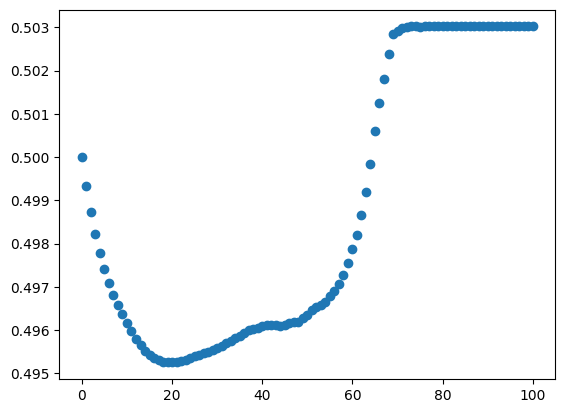

In [6]:
means = []
for h_alpha in adaround_statistics['layer4.0.conv2']['h_alphas']:
    means.append(h_alpha.to("cpu").mean())
plt.scatter([i for i in range(len(means))], means)

In [7]:

layer41conv2 = None
for name, module in quantizized_model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        print(f"Unique weights: {torch.unique(module.weight).shape}")
        if name == "layer4.1.conv2":
            layer41conv2 = module.weight.detach()

baselayer41conv2 = None
for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        if name == "layer4.1.conv2":
            baselayer41conv2 = module.weight.detach()

Unique weights: torch.Size([234])
Unique weights: torch.Size([205])
Unique weights: torch.Size([225])
Unique weights: torch.Size([207])
Unique weights: torch.Size([210])
Unique weights: torch.Size([213])
Unique weights: torch.Size([213])
Unique weights: torch.Size([206])
Unique weights: torch.Size([232])
Unique weights: torch.Size([238])
Unique weights: torch.Size([231])
Unique weights: torch.Size([249])
Unique weights: torch.Size([219])
Unique weights: torch.Size([250])
Unique weights: torch.Size([234])
Unique weights: torch.Size([247])
Unique weights: torch.Size([251])
Unique weights: torch.Size([242])
Unique weights: torch.Size([253])
Unique weights: torch.Size([256])
Unique weights: torch.Size([210])


In [10]:
sortedd = torch.unique(layer41conv2).msort()
distances_between_quantizized_weights = []
for i, val in enumerate(sortedd):
    if i > 0:
        distances_between_quantizized_weights.append((sortedd[i] - sortedd[i-1]).unsqueeze(0))

In [11]:
distances_merged = torch.cat(distances_between_quantizized_weights)
unique_dists = torch.unique(distances_merged)
print("After unique:", unique_dists)

After unique: tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005],
       device='cuda:0')


In [210]:
distances_merged = torch.cat(distances_between_quantizized_weights)
rounded = torch.round(distances_merged * 1e5) / 1e5
unique_dists = torch.unique(rounded)
print("After unique:", unique_dists)

After unique: tensor([0.], device='cuda:0')


In [12]:
torch.equal(unique_dists[0], unique_dists[1])

False

In [10]:
weights = quantizized_model.layer4[1].conv2.weight

In [11]:
print(f"Unique weights: {torch.unique(weights).shape}")

Unique weights: torch.Size([227])


In [12]:
torch.unique(weights)

tensor([-0.0680, -0.0633, -0.0627, -0.0597, -0.0591, -0.0579, -0.0573, -0.0567,
        -0.0561, -0.0549, -0.0543, -0.0537, -0.0531, -0.0525, -0.0519, -0.0513,
        -0.0507, -0.0501, -0.0495, -0.0489, -0.0483, -0.0478, -0.0472, -0.0466,
        -0.0460, -0.0454, -0.0448, -0.0442, -0.0436, -0.0430, -0.0424, -0.0418,
        -0.0412, -0.0406, -0.0400, -0.0394, -0.0388, -0.0382, -0.0376, -0.0370,
        -0.0364, -0.0358, -0.0352, -0.0346, -0.0340, -0.0334, -0.0328, -0.0322,
        -0.0316, -0.0310, -0.0304, -0.0298, -0.0292, -0.0287, -0.0281, -0.0275,
        -0.0269, -0.0263, -0.0257, -0.0251, -0.0245, -0.0239, -0.0233, -0.0227,
        -0.0221, -0.0215, -0.0209, -0.0203, -0.0197, -0.0191, -0.0185, -0.0179,
        -0.0173, -0.0167, -0.0161, -0.0155, -0.0149, -0.0143, -0.0137, -0.0131,
        -0.0125, -0.0119, -0.0113, -0.0107, -0.0101, -0.0096, -0.0090, -0.0084,
        -0.0078, -0.0072, -0.0066, -0.0060, -0.0054, -0.0048, -0.0042, -0.0036,
        -0.0030, -0.0024, -0.0018, -0.00

In [8]:
torch.cat(adaround_statistics['conv1']['losses'])

tensor([1.7280e+02, 1.7120e+02, 1.5990e+02, 1.5421e+02, 1.4789e+02, 1.4133e+02,
        1.3582e+02, 1.2919e+02, 1.2332e+02, 1.1716e+02, 1.0984e+02, 1.0268e+02,
        9.2441e+01, 8.5699e+01, 7.9356e+01, 7.1353e+01, 6.5451e+01, 5.7835e+01,
        5.0220e+01, 4.4286e+01, 3.8756e+01, 3.2609e+01, 2.7788e+01, 2.1478e+01,
        1.5140e+01, 1.2541e+01, 8.6882e+00, 5.9830e+00, 4.8999e+00, 2.8218e+00,
        2.1000e+00, 2.0000e+00, 1.0000e+00, 7.9396e-01, 1.0001e-01, 1.0001e-01,
        1.0001e-01, 1.0001e-01, 1.0001e-01, 1.0001e-01, 1.0001e-01, 1.0001e-01,
        1.0001e-01, 1.0001e-01, 1.0001e-01, 1.0001e-01, 1.0001e-01, 1.0001e-01,
        1.0001e-01, 1.0001e-01, 1.0001e-01, 1.0001e-01, 1.0001e-01, 1.0001e-01,
        1.0001e-01, 1.0001e-01, 1.0001e-01, 1.0001e-01, 1.0001e-01, 1.0001e-01,
        1.0001e-01, 1.0001e-01, 1.0001e-01, 1.2318e-05, 1.2318e-05, 1.2318e-05,
        1.2318e-05, 1.2318e-05, 1.2318e-05, 1.2318e-05, 1.2318e-05, 1.2318e-05,
        1.2318e-05, 1.2318e-05, 1.2318e-

In [9]:
i = 0

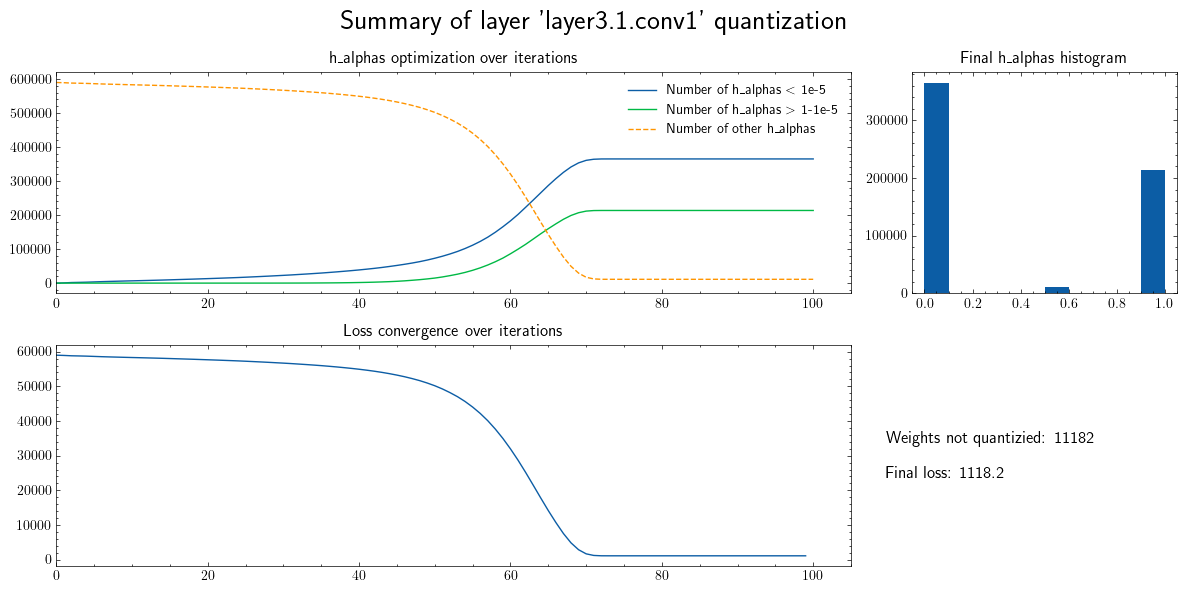

In [23]:
layer_to_plot = list(adaround_statistics.keys())[i]
#layer_to_plot = 'layer3.0.conv2'
i+=1

raveled_h_alphas = []
zeros_count_arr = []
ones_count_arr = []
other_count_arr = []

for h_alphas in adaround_statistics[layer_to_plot]['h_alphas']:
    raveled = torch.ravel(h_alphas.to("cpu")).numpy()
    zeros_count = np.where(raveled < 1e-5)[0].shape[0]
    ones_count = np.where(raveled  > 1-1e-5)[0].shape[0]
    other_count = raveled.shape[0] - zeros_count - ones_count

    zeros_count_arr.append(zeros_count)
    ones_count_arr.append(ones_count)
    other_count_arr.append(other_count)

with plt.style.context('science'):
    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 2, width_ratios=[3, 1])

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    ax0.plot(zeros_count_arr, label='Number of h_alphas $<$ 1e-5')
    ax0.plot(ones_count_arr, label='Number of h_alphas $>$ 1-1e-5')
    ax0.plot(other_count_arr, "--", label='Number of other h_alphas')

    ax0.set_title(f"h_alphas optimization over iterations")
    ax0.legend()
    ax0.set_xlim(left=0)

    ax1.set_title(f"Loss convergence over iterations")

    losses_cpu = torch.cat(adaround_statistics[layer_to_plot]['losses']).to("cpu")
    ax1.plot(losses_cpu)

    ax2.hist(raveled)
    ax2.set_title("Final h_alphas histogram")

    ax3.text(-0.1, 0.4, f"Weights not quantizied: {other_count_arr[-1]:g}\n \nFinal loss: {losses_cpu[-1]:g}", fontsize=12, fontweight='bold')
    ax3.axis('off')

    fig.suptitle(f"Summary of layer '{layer_to_plot}' quantization", fontsize=20)
    plt.tight_layout()
    plt.savefig('/home/mpuscian/Desktop/repozytoria/MINI_projects/anvil/currlayer_summary.pdf')

In [12]:
adaround_statistics[layer_to_plot]['losses'][0] - adaround_statistics[layer_to_plot]['losses_data'][0]

tensor([1.7280e-06])

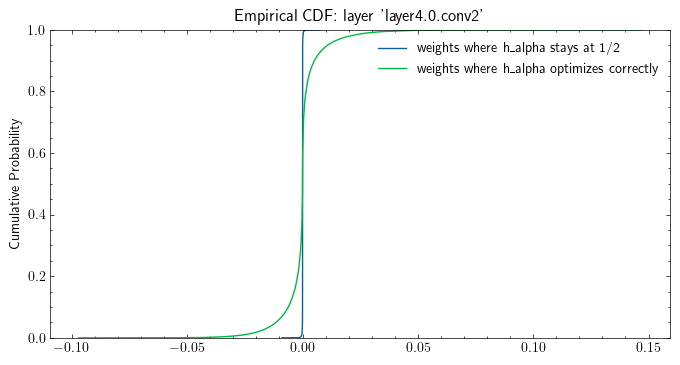

In [634]:
layer_to_plot_cdf = 'layer4.0.conv2'
weights = dict(model.named_modules())[layer_to_plot_cdf].weight
h_alphas = adaround_statistics[layer_to_plot_cdf]['h_alphas'][-1]

weights_halphas05 = weights[h_alphas == 0.5]
weights_halphasnot05 = weights[h_alphas != 0.5]

import scienceplots

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

data_05 = weights_halphas05.detach().cpu().numpy()  # Low variance
data_not05 = weights_halphasnot05.detach().cpu().numpy()  # High variance
x_05, y_05 = ecdf(data_05)
x_not05, y_not05 = ecdf(data_not05)

with plt.style.context('science'):
    plt.figure(figsize=(8, 4))
    plt.plot(x_05, y_05, label="weights where h_alpha stays at 1/2")
    plt.plot(x_not05, y_not05, label="weights where h_alpha optimizes correctly")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.title(f"Empirical CDF: layer '{layer_to_plot_cdf}'")

    plt.ylim(0,1)
    plt.savefig('/home/mpuscian/Desktop/repozytoria/MINI_projects/anvil/currlayer_cdf.pdf')
    #plt.savefig('/home/mpuscian/Desktop/repozytoria/MINI_projects/anvil/img/layer41conv2_CDF.pdf')

In [605]:
i = 0

Unique weights before 2355588
Variance of weights before: 2.0892679458484054e-05
Unique weights after 252
Unique h_alphas at the end: tensor([0.0000, 0.5000, 1.0000], device='cuda:0')
Number of h_alphas 1/2: 1581568


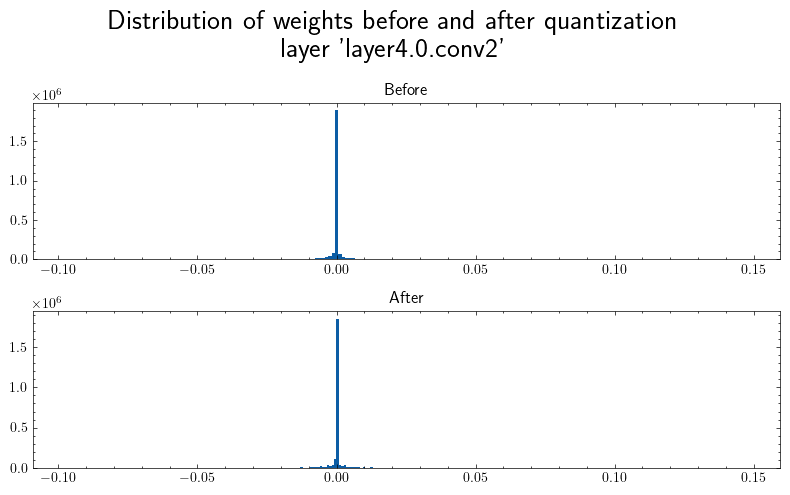

In [622]:
layer_to_plot = list(adaround_statistics.keys())[i]
i+=1
module_to_plot_before = dict(model.named_modules())[layer_to_plot]
_weights_before = torch.ravel(module_to_plot_before.weight.to("cpu").detach())

module_to_plot_after = dict(quantizized_model.named_modules())[layer_to_plot]
_weights_after = torch.ravel(module_to_plot_after.weight.to("cpu").detach())

with plt.style.context('science'):
    fig, axes = plt.subplots(2,1, figsize = (8, 5))
    axes[0].hist(_weights_before, bins=200)
    axes[1].hist(_weights_after, bins=200)
    axes[1].set_xlim(axes[0].get_xlim())

    axes[0].set_title("Before")
    axes[1].set_title("After")
    fig.suptitle(f"Distribution of weights before and after quantization\n layer '{layer_to_plot}'", fontsize = 20)
    plt.tight_layout()
    plt.savefig('/home/mpuscian/Desktop/repozytoria/MINI_projects/anvil/curr_layer_weights_comparison.pdf')


print("Unique weights before", torch.unique(_weights_before).shape[0])
print(f"Variance of weights before: {torch.var(_weights_before)}")
print("Unique weights after", torch.unique(_weights_after).shape[0])
print(f"Unique h_alphas at the end: {torch.unique(adaround_statistics[layer_to_plot]['h_alphas'][-1])}")
end_h_alphas = torch.ravel(adaround_statistics[layer_to_plot]['h_alphas'][-1]).cpu().numpy()
print(f"Number of h_alphas 1/2: {end_h_alphas.shape[0] - np.where(end_h_alphas < 1/2)[0].shape[0] - np.where(end_h_alphas > 1/2)[0].shape[0]}")

In [72]:
torch.unique(_weights_after.msort())

tensor([-0.2075, -0.1858, -0.1843, -0.1827, -0.1796, -0.1750, -0.1734, -0.1672,
        -0.1626, -0.1610, -0.1595, -0.1579, -0.1548, -0.1471, -0.1440, -0.1425,
        -0.1409, -0.1394, -0.1378, -0.1363, -0.1347, -0.1332, -0.1316, -0.1301,
        -0.1285, -0.1270, -0.1254, -0.1239, -0.1223, -0.1208, -0.1192, -0.1177,
        -0.1161, -0.1146, -0.1130, -0.1115, -0.1099, -0.1084, -0.1068, -0.1053,
        -0.1037, -0.1022, -0.1007, -0.0991, -0.0976, -0.0960, -0.0945, -0.0929,
        -0.0914, -0.0898, -0.0883, -0.0867, -0.0852, -0.0836, -0.0821, -0.0805,
        -0.0790, -0.0774, -0.0759, -0.0743, -0.0728, -0.0712, -0.0697, -0.0681,
        -0.0666, -0.0650, -0.0635, -0.0619, -0.0604, -0.0588, -0.0573, -0.0557,
        -0.0542, -0.0526, -0.0511, -0.0496, -0.0480, -0.0465, -0.0449, -0.0434,
        -0.0418, -0.0403, -0.0387, -0.0372, -0.0356, -0.0341, -0.0325, -0.0310,
        -0.0294, -0.0279, -0.0263, -0.0248, -0.0232, -0.0217, -0.0201, -0.0186,
        -0.0170, -0.0155, -0.0139, -0.01

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 9.000e+00,
        7.000e+00, 3.000e+00, 5.000e+00, 1.500e+01, 9.000e+00, 8.000e+00,
        9.000e+00, 7.000e+00, 1.200e+01, 9.000e+00, 2.000e+01, 2.200e+01,
        1.600e+01, 1.300e+01, 4.700e+01, 2.000e+01, 2.300e+01, 2.700e+01,
        6.200e+01, 3.600e+01, 4.600e+01, 8.800e+01, 6.000e+01, 6.000e+01,
        5.200e+01, 1.080e+02, 7.900e+01, 8.400e+01, 8.000e+01, 1.600e+02,
        9.300e+01, 8.300e+01, 2.060e+02, 1.160e+02, 1.170e+02, 1.260e+02,
        3.140e+02, 1.710e+02, 1.780e+02, 1.910e+02, 3.970e+02, 2.110e+02,
        2.180e+02, 2.200e+02, 4.890e+02, 2.670e+02, 2.520e+02, 6.010e+02,
        2.930e+02, 3.080e+02, 3.510e+0

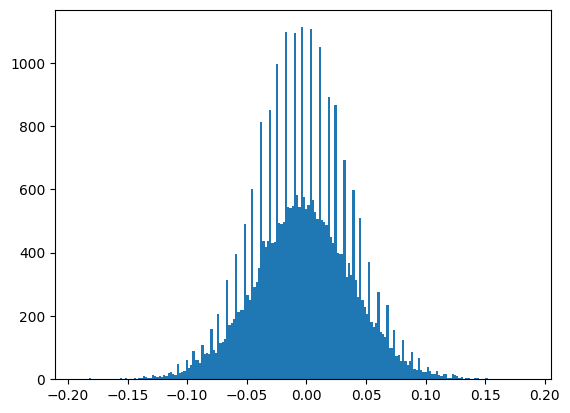

In [111]:
plt.hist(_weights_after, bins = 200)

In [113]:
np.histogram(dict(quantizized_model.named_modules())[layer_to_plot].cpu().weight.detach(), bins=100)

(array([   2,    0,    3,    1,    0,    1,    2,    2,    3,    5,    3,
           4,    6,    5,   12,   10,   20,   17,   16,   21,   42,   29,
          67,   50,   98,  134,  120,  160,  163,  240,  176,  322,  243,
         485,  369,  608,  438,  756,  853,  601, 1165,  854, 1287,  864,
        1491,  987, 1643, 1089, 1675, 1655, 1115, 1656, 1094, 1557,  999,
        1380,  879, 1268,  793, 1018,  698,  914,  769,  478,  577,  345,
         454,  292,  370,  197,  229,  136,  182,  101,  117,   95,   53,
          63,   43,   42,   22,   35,    9,   28,   13,   10,    8,    3,
           9,    3,    5,    0,    2,    2,    1,    0,    1,    0,    1,
           1]),
 array([-0.19214441, -0.1883611 , -0.1845778 , -0.18079448, -0.17701118,
        -0.17322786, -0.16944456, -0.16566125, -0.16187795, -0.15809463,
        -0.15431133, -0.15052801, -0.14674471, -0.1429614 , -0.13917808,
        -0.13539478, -0.13161147, -0.12782817, -0.12404486, -0.12026154,
        -0.11647823, -0.11

In [53]:
torch.quantile(torch.ravel(dict(model.named_modules())[layer_to_plot].weight),0.01)

tensor(-0.1035, grad_fn=<SqueezeBackward4>)

In [ ]:
Processing modules - Current: layer4.0.conv2: : 53it [00:35,  1.63it/s]
min: -0.0001544490660307929, max: 7.715923129580915e-05

In [54]:
np.histogram(_weights_before, bins=100)

(array([   2,    0,    2,    3,    1,    6,    4,    3,    5,    2,    1,
           1,   13,   13,   18,   15,   21,   24,   22,   38,   53,   53,
          77,   78,  102,  114,  152,  186,  222,  256,  299,  345,  391,
         441,  583,  645,  702,  825,  869, 1032, 1101, 1262, 1423, 1684,
        1962, 2264, 2310, 1809, 1460, 1247, 1051,  986,  856,  782,  707,
         568,  474,  397,  395,  341,  306,  237,  235,  178,  187,  154,
         125,   93,   85,   71,   78,   50,   44,   33,   41,   34,   16,
          16,   18,   14,   11,   10,    7,    9,    1,    1,    1,    1,
           2,    1,    5,    0,    0,    0,    1,    1,    2,    1,    0,
           1]),
 array([-0.20087695, -0.19652581, -0.19217467, -0.18782353, -0.1834724 ,
        -0.17912127, -0.17477013, -0.170419  , -0.16606785, -0.16171671,
        -0.15736558, -0.15301444, -0.1486633 , -0.14431216, -0.13996103,
        -0.1356099 , -0.13125876, -0.12690762, -0.12255648, -0.11820534,
        -0.1138542 , -0.10

In [57]:
y_true, y_pred = evaluate_model(model, test_loader, 'cuda:0')
print(f"accuracy before quantization: {metrics.accuracy_score(y_true, y_pred)}")
print(f"f1 score before quantization: {metrics.f1_score(y_true, y_pred, average='weighted'):.4f}")

accuracy before quantization: 0.8258
f1 score before quantization: 0.8268


In [58]:
y_true, y_pred = evaluate_model(quantizized_model, test_loader, 'cuda:0')
print(f"accuracy after quantization: {metrics.accuracy_score(y_true, y_pred)}")
print(f"f1 score after quantization: {metrics.f1_score(y_true, y_pred, average='weighted'):.4f}")

accuracy after quantization: 0.8105
f1 score after quantization: 0.8122


**one channel quantization, 2 bits, 1 calibration sample(RANDOM)** <br>
acc : 0.2918

# Grid search

In [ ]:
lr : [0.05, 0.01, 0.005, 0.001]
reg_param: [0.1, 0.07, 0.05, 0.01, 0.005]
num_iteration: [500, 1000, 2000, 3000, 4000]
beta_range: [(10, 2), (20, 2), (40,2), (20,1), (20,0.5)]

In [100]:
params = {
    'bitwidth' : 8,
    'reg_param' : 0.05,
    'num_iterations' : 2000,
    'per_channel' : False,
    'beta_range' : (20, 2),
    'optimizer_lr' : 0.005

}

In [94]:
adaround_wrapper = anvil.adaround.AdaRoundModelWrapper(model, images_1)
adaround_statistics, quantizized_weights, quantizized_model = adaround_wrapper.apply_adaround_to_layers(**params)

Quantizizing conv and lin
 params:  8 0.05 False 2000 (20, 2) 0.001


Processing modules - Current: fc: : 68it [00:44,  1.52it/s]                   


In [95]:
y_true, y_pred = evaluate_model(quantizized_model, test_loader, 'cuda:0')

parameter_search[int(np.max(list(parameter_search.keys())) + 1)] = {
    'params' : params,
    'accuracry' : metrics.accuracy_score(y_true, y_pred),
    'f1_Score' : metrics.f1_score(y_true, y_pred, average='macro'),
    'y_pred' : y_pred,
    'y_true' : y_true
}

In [96]:
parameter_search

{0: {'params': {'bitwidth': 8,
   'reg_param': 0.01,
   'num_iterations': 1000,
   'per_channel': False,
   'beta_range': (20, 2),
   'optimizer_lr': 0.01},
  'accuracry': 0.8224,
  'f1_Score': 0.8235657650517343,
  'y_pred': tensor([3, 8, 1,  ..., 5, 1, 7]),
  'y_true': tensor([3, 8, 8,  ..., 5, 1, 7])},
 1: {'params': {'bitwidth': 8,
   'reg_param': 0.05,
   'num_iterations': 1000,
   'per_channel': False,
   'beta_range': (20, 2),
   'optimizer_lr': 0.01},
  'accuracry': 0.8235,
  'f1_Score': 0.8245692559755922,
  'y_pred': tensor([3, 8, 1,  ..., 5, 1, 7]),
  'y_true': tensor([3, 8, 8,  ..., 5, 1, 7])},
 2: {'params': {'bitwidth': 8,
   'reg_param': 0.1,
   'num_iterations': 1000,
   'per_channel': False,
   'beta_range': (20, 2),
   'optimizer_lr': 0.01},
  'accuracry': 0.8231,
  'f1_Score': 0.8242453575956576,
  'y_pred': tensor([3, 8, 1,  ..., 5, 1, 7]),
  'y_true': tensor([3, 8, 8,  ..., 5, 1, 7])},
 3: {'params': {'bitwidth': 8,
   'reg_param': 0.05,
   'num_iterations': 500,
 

# Mean acc

In [150]:
accuracies = []
for i in range(5):
    indices = torch.randperm(images.size(0))[:50]
    sample_images = torch.cat(images_list, dim=0)[indices]
    
    adaround_wrapper = anvil.adaround.AdaRoundModelWrapper(model, sample_images)
    adaround_statistics, quantizized_weights, quantizized_model = adaround_wrapper.apply_adaround_to_layers(reg_param=2, bitwidth=8, per_channel=False, num_iterations=3500, beta_range=(20, 2), optimizer_lr=3e-2, use_quantiles=False)

    y_true, y_pred = evaluate_model(quantizized_model, test_loader, 'cuda:0')
    accuracies.append(metrics.accuracy_score(y_true, y_pred))

Quantizizing conv and lin
 params:  8 2 False 3500 (20, 2) 0.03


Processing modules - Current: fc: : 68it [01:25,  1.25s/it]                   


Quantizizing conv and lin
 params:  8 2 False 3500 (20, 2) 0.03


Processing modules - Current: fc: : 68it [01:24,  1.25s/it]                   


Quantizizing conv and lin
 params:  8 2 False 3500 (20, 2) 0.03


Processing modules - Current: fc: : 68it [01:24,  1.25s/it]                   


Quantizizing conv and lin
 params:  8 2 False 3500 (20, 2) 0.03


Processing modules - Current: fc: : 68it [01:25,  1.25s/it]                   


Quantizizing conv and lin
 params:  8 2 False 3500 (20, 2) 0.03


Processing modules - Current: fc: : 68it [01:22,  1.22s/it]                   


In [139]:
y_true, y_pred = evaluate_model(model, test_loader, 'cuda:0')
print(f"accuracy before quantization: {metrics.accuracy_score(y_true, y_pred)}")
print(f"f1 score before quantization: {metrics.f1_score(y_true, y_pred, average='weighted'):.4f}")

accuracy before quantization: 0.8258
f1 score before quantization: 0.8268


In [151]:
print(f"Adaround: {np.mean(accuracies)} +- {np.std(accuracies):.4f}")

Adaround: 0.8251799999999999 +- 0.0004


In [152]:
accuracies

[0.8244, 0.8252, 0.8255, 0.8252, 0.8256]

In [ ]:
#saving
#import pickle
#with open('/home/mpuscian/Desktop/repozytoria/MINI_projects/anvil/accuracies_8bit.pkl', 'wb') as f:
#    pickle.dump(accuracies, f)

In [ ]:
# opening
#with open('/home/mpuscian/Desktop/repozytoria/MINI_projects/anvil/accuracies_8bit.pkl', 'rb') as f:
#    aaa = pickle.load(f)